<a href="https://colab.research.google.com/github/JLongStem3/Image-Detection-ASL-USD_MS_AAI-521/blob/main/MobileNetV3_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
#!pip install kagglehub
#!pip install tensorflow

import kagglehub
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

In [ ]:
# Download the dataset from Kaggle
path = kagglehub.dataset_download("datamunge/sign-language-mnist")
print("Path to dataset files:", path)

# Load training and testing data
train_data = pd.read_csv(f"{path}/sign_mnist_train.csv")
test_data = pd.read_csv(f"{path}/sign_mnist_test.csv")

100%|██████████| 62.6M/62.6M [00:03<00:00, 19.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1


In [ ]:
# Define constants for data handling
BATCH_SIZE = 32
IMG_HEIGHT = 96
IMG_WIDTH = 96
NUM_CLASSES = 25

# Create tf.data.Dataset for Training and Test Data
def preprocess_image(image, label):
    # Reshape to 28x28 and add channel dimension
    image = tf.reshape(image, [28, 28, 1])
    # Resize to 96x96
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    # Convert grayscale (1 channel) to RGB (3 channels)
    image = tf.image.grayscale_to_rgb(image)
    # Normalize pixel values
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def load_dataset_from_dataframe(dataframe):
    # Extract features and labels
    labels = dataframe.iloc[:, 0].values
    images = dataframe.iloc[:, 1:].values

    # Convert labels to one-hot encoding
    labels = tf.keras.utils.to_categorical(labels, NUM_CLASSES)

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
    dataset = dataset.map(preprocess_image)
    dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [ ]:
# Prepare training, validation, and test datasets
train_val_split = int(len(train_data) * 0.9)
train_df = train_data.iloc[:train_val_split]
val_df = train_data.iloc[train_val_split:]

train_dataset = load_dataset_from_dataframe(train_df)
val_dataset = load_dataset_from_dataframe(val_df)
test_dataset = load_dataset_from_dataframe(test_data)

In [ ]:
# Load and Modify MobileNetV3 for Fine-Tuning
# Load the base MobileNetV3 model with ImageNet weights
base_model = MobileNetV3Small(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')

# Add custom layers for our specific classification task
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the Model Using the Dataset
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20)

Epoch 1/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 129s 90ms/step - accuracy: 0.0619 - loss: 3.7196 - val_accuracy: 0.0339 - val_loss: 3.3519
Epoch 2/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - accuracy: 0.1431 - loss: 2.9670 - val_accuracy: 0.0412 - val_loss: 3.4677
Epoch 3/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.2795 - loss: 2.4891 - val_accuracy: 0.0393 - val_loss: 3.4494
Epoch 4/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.4366 - loss: 1.9590 - val_accuracy: 0.0510 - val_loss: 3.5853
Epoch 5/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.5773 - loss: 1.4445 - val_accuracy: 0.0590 - val_loss: 3.7829
Epoch 6/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.6887 - loss: 1.0461 - val_accuracy: 0.1336 - val_loss: 3.0249
Epoch 7/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.7684 - loss: 0.7625 - val_accuracy: 0.3150 - val_loss: 2.2068
Epoch 8/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - accuracy: 0.8337 - loss: 0.5527 -

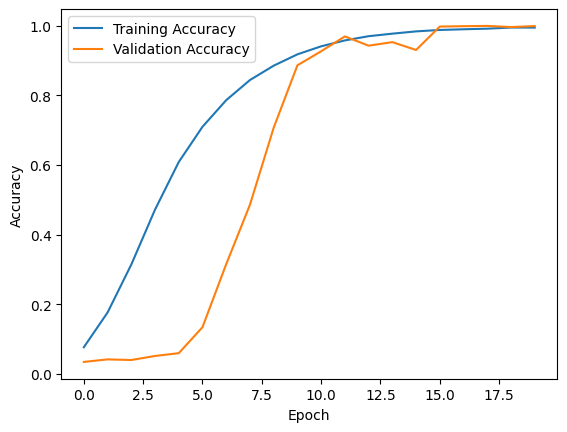

In [ ]:
# Plot Training History
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate the Model on the Test Set
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 93.75%


In [ ]:
# Display Example Images and Predictions
def plot_predictions(dataset, num_images=5):
    plt.figure(figsize=(15, 5))
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        for i in range(num_images):
            plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy(), vmin=0, vmax=1)
            true_label = tf.argmax(labels[i])
            pred_label = tf.argmax(preds[i])
            plt.title(f"True: {true_label}, Pred: {pred_label}")
            plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


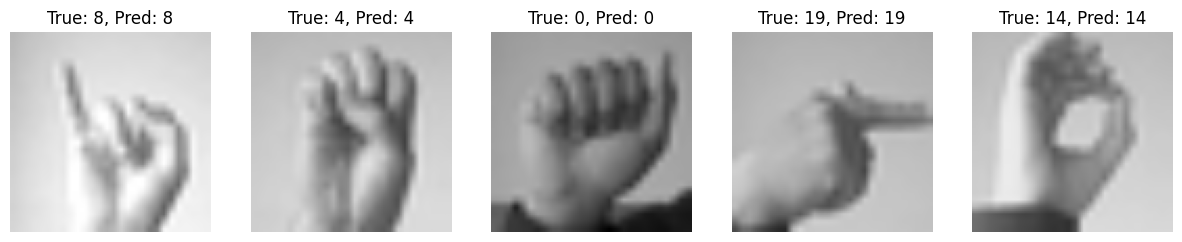

In [ ]:
# Plot a few predictions
plot_predictions(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


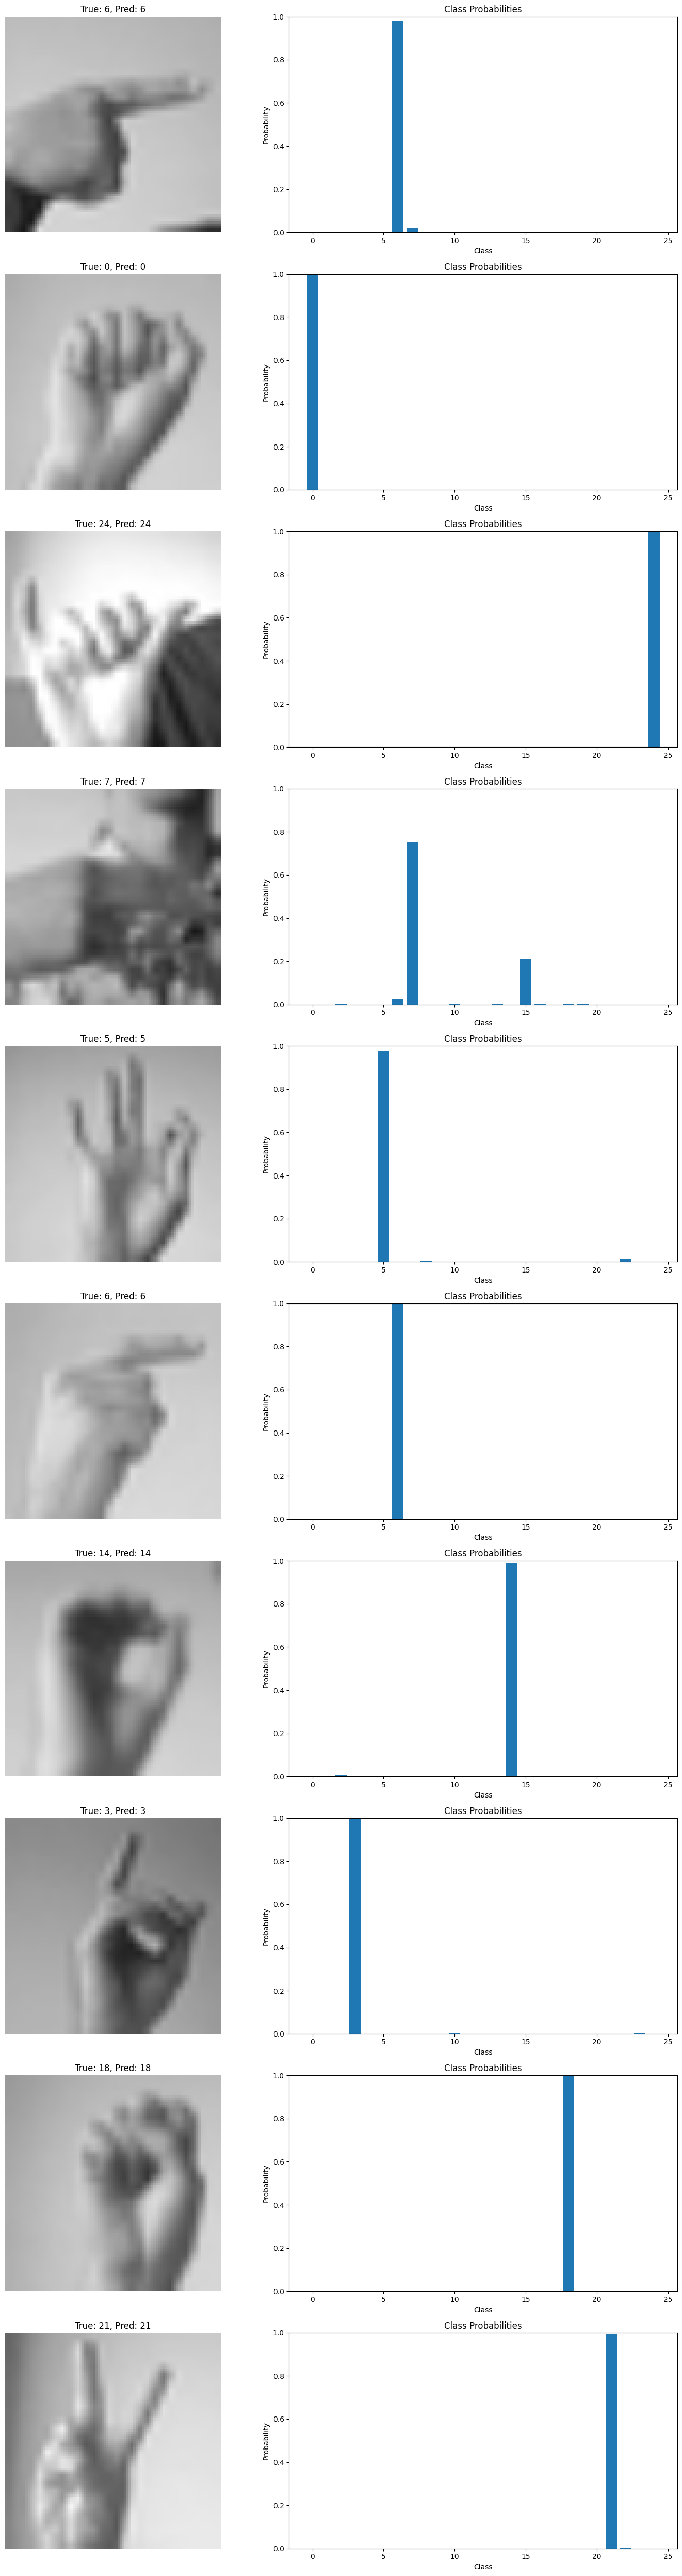

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

def list_first_n_examples_with_probabilities(dataset, model, n=5):
    """
    List the first n examples in the test set with their predicted and actual labels,
    and display the softmax probabilities for each output class.

    Parameters:
    - dataset: tf.data.Dataset, the test dataset to use for predictions
    - model: keras.Model, the trained model for predictions
    - n: int, number of examples to display

    Returns:
    - None
    """
    plt.figure(figsize=(15, n * 5))
    example_count = 0

    # Loop over the dataset
    for images, labels in dataset.take(1):
        # Get the model predictions
        predictions = model.predict(images)

        # Iterate over the images and labels
        for i in range(min(n, len(images))):
            true_label = tf.argmax(labels[i]).numpy()  # Actual label
            predicted_label = tf.argmax(predictions[i]).numpy()  # Predicted label
            probabilities = predictions[i]  # Softmax output - probabilities for each class

            # Plot the image
            plt.subplot(n, 2, 2 * i + 1)
            plt.imshow(images[i].numpy(), vmin=0, vmax=1)
            plt.title(f"True: {true_label}, Pred: {predicted_label}")
            plt.axis('off')

            # Plot the softmax probabilities
            plt.subplot(n, 2, 2 * i + 2)
            plt.bar(range(len(probabilities)), probabilities)
            plt.title("Class Probabilities")
            plt.xlabel("Class")
            plt.ylabel("Probability")
            plt.ylim([0, 1])

            example_count += 1
            if example_count >= n:
                break

    plt.tight_layout()
    plt.show()

# Call the function to list first n examples from the test set with their predicted and actual labels
list_first_n_examples_with_probabilities(test_dataset, model, n=10)
